In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [24]:
# df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)
df_tile["gt overlap norm tarea"]=df_tile["gt overlap area"]/df_tile["tile area"]
df = df_worker.merge(df_tile)

In [25]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr,split=[0.7,0.85],delta=0.03,plot_two_col=False):
    bin2size={0:'small',1:'medium',2:'large'}
    df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    # if len(df_tile_subset)==0: return
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = np.array(df_tile_subset["tile id"])
    tile_area = np.array(df_tile_subset["tile area"])
    bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
    bin_idx = np.digitize(tile_area,bin_edges)
    if plot_two_col: 
        fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
    for size in list(set(bin_idx)):
        if (not plot_two_col): plt.figure()
        idx = np.where(bin_idx==size)[0]
        if len(idx)!=0:
            for tidx in tile_lst[idx]:
                worker_lst = list(set(df_worker_tile_subset["worker id"]))
                yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
                no_workers =[w for w in worker_lst if w not in yes_workers]
                selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
                no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]
                if plot_two_col: 
                    
                    xdata1 = np.array(no_selected["gt overlap norm tarea"])
                    ydata1 = np.array(no_selected[y_attr])

                    ax.plot(xdata1, ydata1,'x',color='red')
                    ax2.plot(xdata1, ydata1,'x',color='red')

                    xdata = np.array(selected["gt overlap norm tarea"])
                    ydata = np.array(selected[y_attr])
                    ax.plot(xdata, ydata,'.',color='green')
                    ax2.plot(xdata, ydata,'.',color='green')

                    ymin,ymax= ax.get_ylim()
                    ax.set_ylim(0.5,split[0]) # Definition of bad workers
                    ax2.set_ylim(split[1],1)# Definition of good workers
                    
                    fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
                    fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
                    fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)
                    plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
                else:
                    xdata1 = np.array(no_selected["gt overlap norm tarea"])
                    ydata1 = np.array(no_selected[y_attr])
                    plt.plot(xdata1, ydata1,'x',color='red')

                    xdata = np.array(selected["gt overlap norm tarea"])
                    ydata = np.array(selected[y_attr])
                    plt.plot(xdata, ydata,'.',color='green')
                    plt.xlabel("Overlap Fraction",fontsize=13)
                    plt.ylabel(y_attr,fontsize=13)
                    plt.title("{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
                    plt.legend(['unvoted','voted'],bbox_to_anchor=(1.3,1), loc="upper right",fontsize=12)
            plt.xlim(-0.1,1.1)

            plt.tight_layout()

In [26]:
batch = '5workers_rand0'
wid = 196
df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
weighted_qj_tbl = []
for objid in list(set(df_object["objid"])):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    image_area = float(df_object[df_object["objid"]==objid]["Image area"])
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_worker_tile_subset["tile id"]))
    for wid in list(set(df_worker_tile_subset["worker id"])):#list(set(df_worker["worker id"])):
        voted_tiles = list(df_worker_tile_subset[df_worker_tile_subset["worker id"]==wid]["tile id"])
        if len(voted_tiles)>0:
            non_voted_tiles =[t for t in tile_lst if t not in voted_tiles]
            voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(voted_tiles)]["gt overlap area"].sum()
            non_voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(non_voted_tiles)]["outside area"].sum()
            outer_portion_area = image_area - (df_tile_subset[df_tile_subset["tile id"].isin(voted_tiles)]["tile area"].sum()+df_tile_subset[df_tile_subset["tile id"].isin(non_voted_tiles)]["tile area"].sum())
            weighted_qj =(non_voted_area_term+voted_area_term+outer_portion_area)/image_area
            weighted_qj_tbl.append([wid,weighted_qj])

weighted_qj_tbl = pd.DataFrame(weighted_qj_tbl,columns=["worker id","weighted qj"])
df_worker = df_worker.merge(weighted_qj_tbl)
df = df_worker.merge(df_tile)

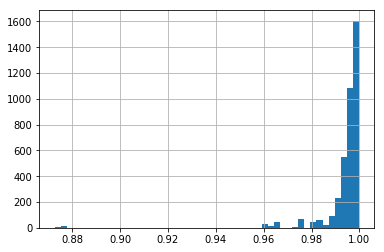

In [29]:
df_worker["weighted qj"].hist(bins=50)

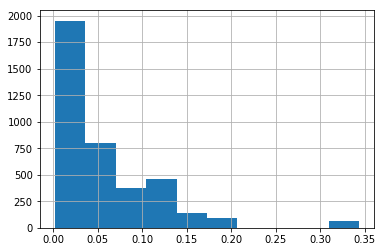

In [34]:
df_worker["weighted qj"].hist()

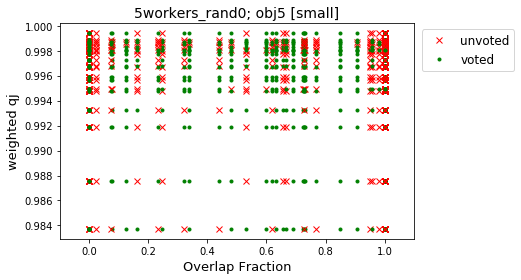

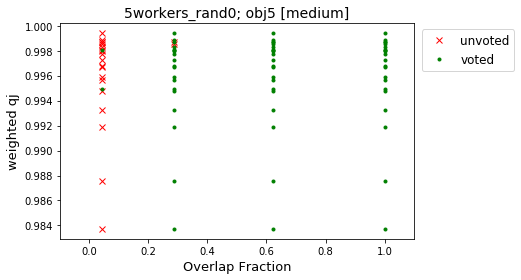

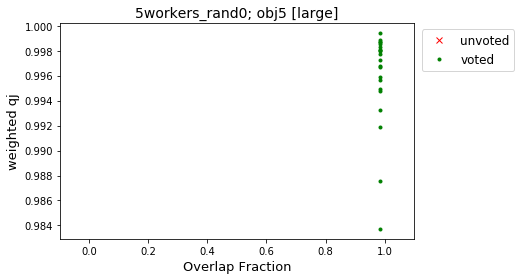

In [30]:
plot_overlap_vs_worker_quality('5workers_rand0',5,"weighted qj")

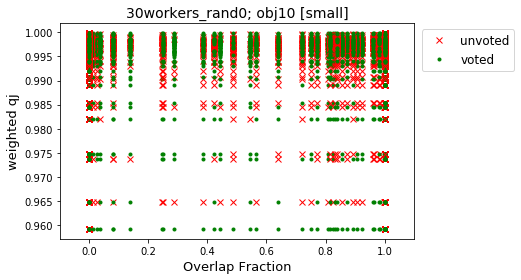

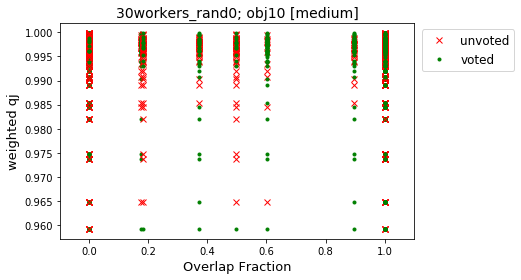

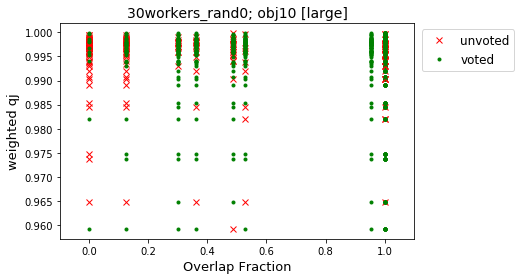

In [31]:
plot_overlap_vs_worker_quality('30workers_rand0',10,"weighted qj")

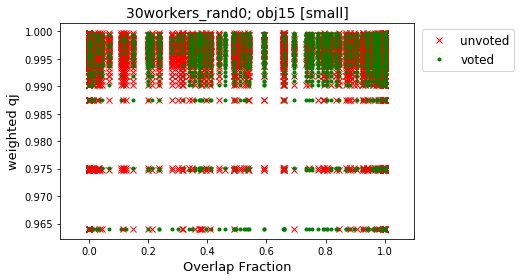

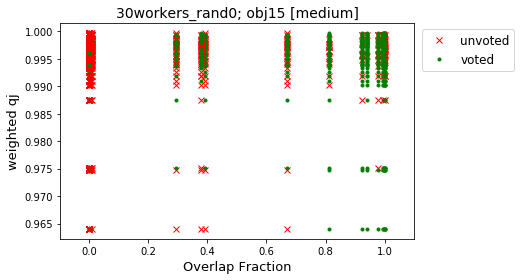

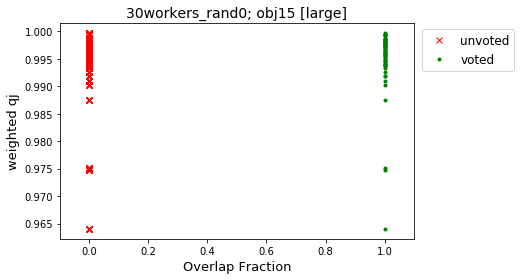

In [32]:
plot_overlap_vs_worker_quality('30workers_rand0',15,"weighted qj")